In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [17]:
def load_and_prepare_data(file_path):
    """Carga y prepara los datos iniciales"""
    df = pd.read_csv(file_path)
    
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Crear variables derivadas adicionales
    df['deficit_real'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['margen_seguridad'] = df['disponibilidad_total'] - df['demanda_maxima']
    df['eficiencia_07am'] = df['disponibilidad_07am'] / df['disponibilidad_total'] * 100
    df['utilizacion_07am'] = df['demanda_07am'] / df['disponibilidad_07am'] * 100
    
    # Categorizar días
    df['tipo_dia'] = df['dia_semana'].map({
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    })
    
    return df


file_path = '../data/processed/cleaned_energy_data.csv'
df = load_and_prepare_data(file_path)

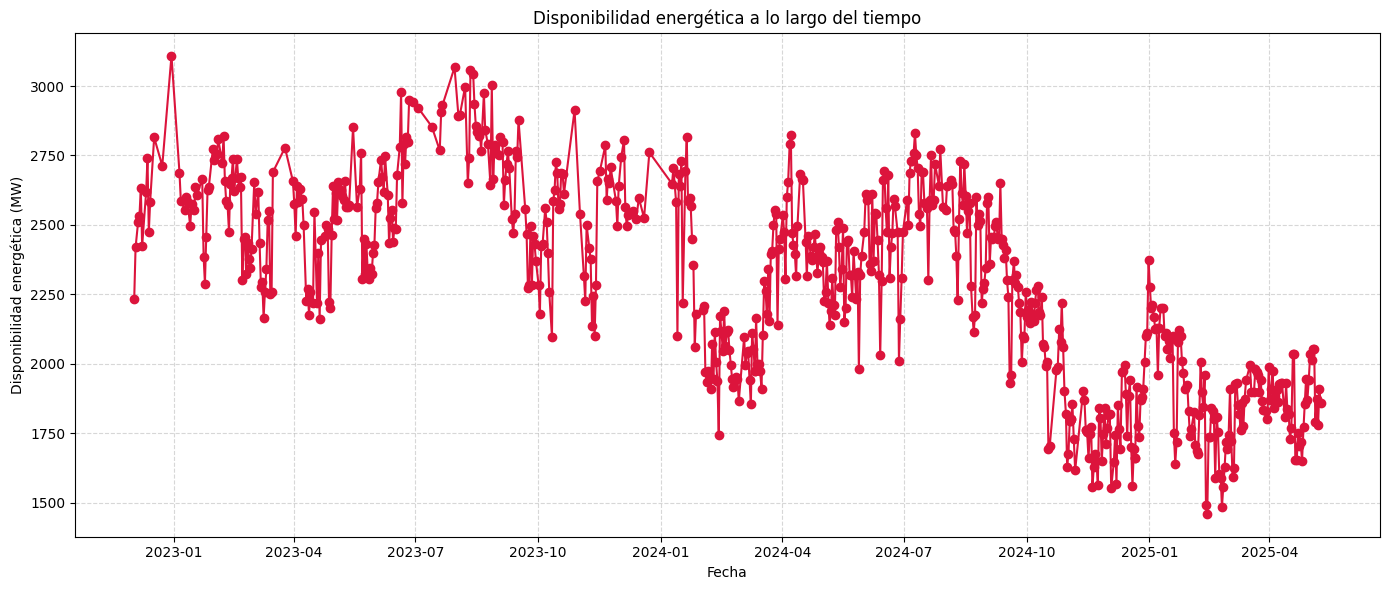

In [18]:
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'fecha' esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Si no existe la columna deficit_real, créala (según tu función)
if 'disponibilidad_total' not in df.columns:
    df['disponibilidad_total'] = df['disponibilidad_total'] - df['disponibilidad_total']

# Ordenar por fecha (por si acaso)
df = df.sort_values('fecha')

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(df['fecha'], df['disponibilidad_total'], marker='o', linestyle='-', color='crimson')
plt.xlabel('Fecha')
plt.ylabel('Disponibilidad energética (MW)')
plt.title('Disponibilidad energética a lo largo del tiempo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [19]:
features = ['disponibilidad_07am','mw_motores_problemas','mw_limitacion_termica','mes','plantas_averiadas']
X = df[features]
y = df['disponibilidad_total']

# Eliminar filas con valores nulos
X_clean = X.dropna()
y_clean = y[X_clean.index]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [20]:
# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluación
y_pred_rf = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
medae = median_absolute_error(y_test, y_pred_rf)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', f'{mape:.2%}')
print('MedAE:', medae)

Mejores hiperparámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 12914.412110546877
R²: 0.8978488937359399
MAE: 86.50843750000001
RMSE: 113.64159498417328
MAPE: 3.83%
MedAE: 71.57500000000005


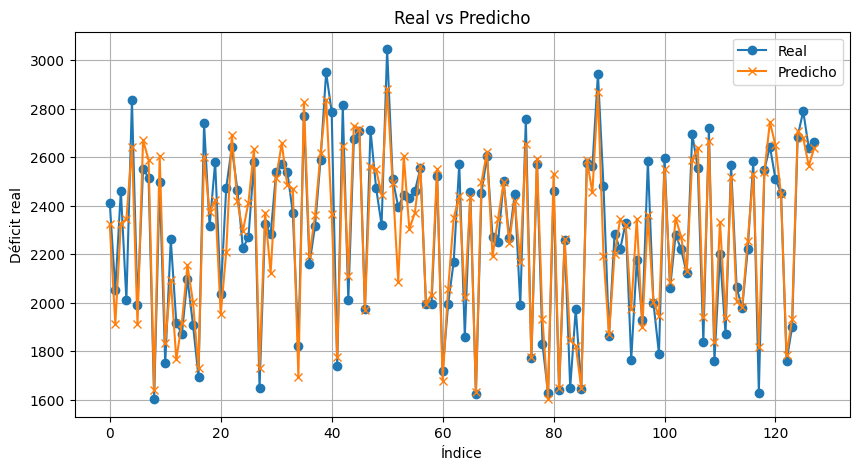

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred_rf, label='Predicho', marker='x')
plt.title('Real vs Predicho')
plt.xlabel('Índice')
plt.ylabel('Déficit real')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# 5. Escalado de features (muy importante para SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Búsqueda de hiperparámetros para SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)



# 7. Evaluación del mejor modelo
best_svr = grid_search.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
mae = mean_absolute_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_svr)
medae = median_absolute_error(y_test, y_pred_svr)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', f'{mape:.2%}')
print('MedAE:', medae)

Mejores hiperparámetros: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
MSE: 15959.942423554188
R²: 0.873759195500249
MAE: 94.27091353641455
RMSE: 126.33266570271597
MAPE: 4.24%
MedAE: 66.33520505742399


# Analisis con Series temporales

Idealmente: no debe haber grandes huecos entre fechas (como semanas enteras faltantes), o al menos deberías saber que no te afecta mucho.

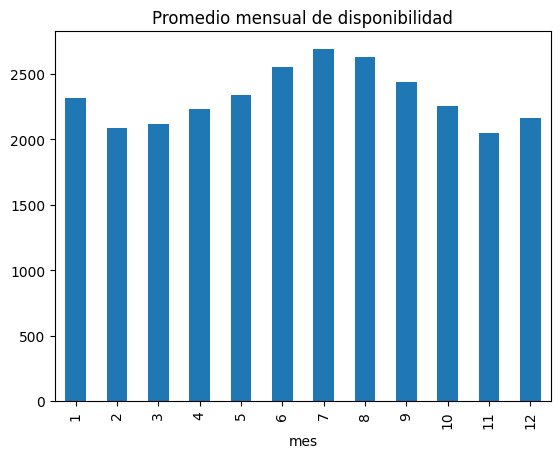

In [24]:
df['mes'] = df['fecha'].dt.month
df.groupby('mes')['disponibilidad_total'].mean().plot(kind='bar')
plt.title('Promedio mensual de disponibilidad')
plt.show()


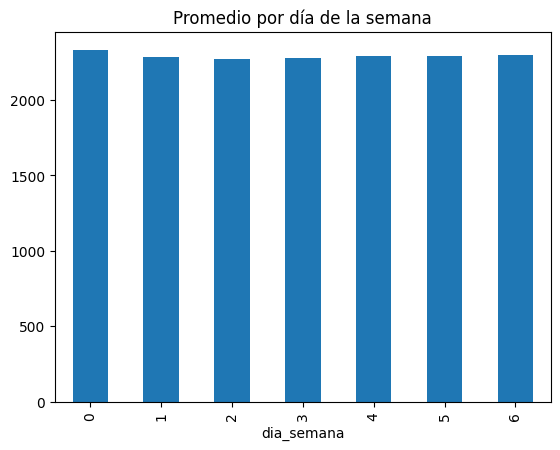

In [25]:
df['dia_semana'] = df['fecha'].dt.dayofweek
df.groupby('dia_semana')['disponibilidad_total'].mean().plot(kind='bar')
plt.title('Promedio por día de la semana')
plt.show()


¿el valor de hoy depende del de ayer? Lo puedes verificar con un gráfico de autocorrelación. 

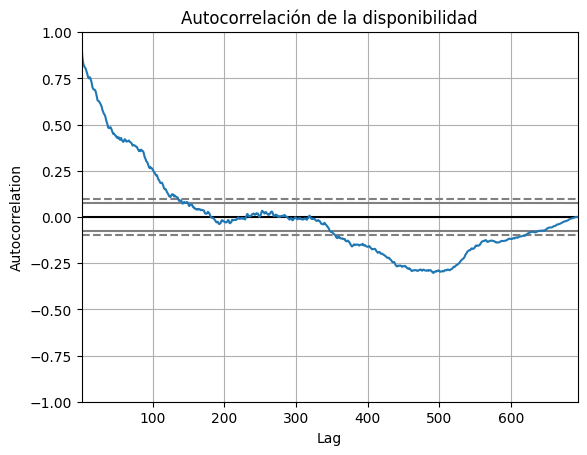

In [27]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['disponibilidad_total'].dropna())
plt.title("Autocorrelación de la disponibilidad")
plt.show()

In [28]:
conteo_por_año = df['año'].value_counts().sort_index()
print("Cantidad de datos por año:")
print(conteo_por_año)

#ver en que fila empieza cada año
for año in sorted(df['año'].unique()):
    fila_inicio = df[df['año'] == año].index[0]
    print(f"Año {año} empieza en la fila {fila_inicio}")


Cantidad de datos por año:
año
2022     13
2023    230
2024    331
2025    122
Name: count, dtype: int64
Año 2022 empieza en la fila 12
Año 2023 empieza en la fila 30
Año 2024 empieza en la fila 257
Año 2025 empieza en la fila 602


Esto pasa por la cantidad de datos que faltan por annos. Al ver el intervalo que ocupa 2024 que es el que mas datos registra y el de 2025 que estan bien todos los dias se puede ver que si va a tender a cumplir con ser una serie estacionaria. Cumple la utocorrelacion en los intervalos de datos buenos

In [26]:
from statsmodels.tsa.stattools import adfuller
# Prueba ADF para 'disponibilidad_total'
result = adfuller(df['disponibilidad_total'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.7936680902827866
p-valor: 0.3836098115775268
Valores críticos:
   1%: -3.4399889432093325
   5%: -2.865793456189478
   10%: -2.5690350878361916


No cumple con ser una serie estacionaria por el p-valor mayor a 0,

In [29]:
for lag in range(1, 10):
    df[f'disponibilidad_total_lag_{lag}'] = df['disponibilidad_total'].shift(lag)

correlations = df[[f'disponibilidad_total_lag_{i}' for i in range(1, 10)] + ['disponibilidad_total']].corr()

print(correlations['disponibilidad_total'])


disponibilidad_total_lag_1    0.913396
disponibilidad_total_lag_2    0.867034
disponibilidad_total_lag_3    0.840085
disponibilidad_total_lag_4    0.825059
disponibilidad_total_lag_5    0.819706
disponibilidad_total_lag_6    0.815361
disponibilidad_total_lag_7    0.806994
disponibilidad_total_lag_8    0.794764
disponibilidad_total_lag_9    0.783465
disponibilidad_total          1.000000
Name: disponibilidad_total, dtype: float64


Un modelo de series temporales toma en cuenta la secuencia y dependencia temporal de los datos. No solo entrena con datos pasados, sino que evita mirar el futuro para predecir el pasado

A. Entrenamiento respetando el tiempo
Nunca mezclás aleatoriamente el orden de los datos.

El train_test_split se hace por tiempo, no al azar.

Se usa TimeSeriesSplit en vez de KFold.

B. Ingeniería de features temporal
Se agregan lags (valores pasados) como predictores.
Ej.: para predecir la disponibilidad de hoy, usás la de ayer y anteayer.

In [39]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Cargar y ordenar datos
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')  

# Crear lags
def create_lag_features(df, target_col, lags=range(1, 8)):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

df_lagged = create_lag_features(df, 'disponibilidad_total')

# Features y target
basic_features = ['disponibilidad_07am', 'mw_motores_problemas', 'mw_limitacion_termica', 'mes', 'plantas_averiadas']
lag_features = [f'disponibilidad_total_lag_{i}' for i in range(1, 8)]
all_features = basic_features + lag_features

df_lagged = df_lagged.dropna()
X = df_lagged[all_features]
y = df_lagged['disponibilidad_total']

# División temporal
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# Entrenamiento
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
model.fit(X_train, y_train)
best_gb = model.best_estimator_
y_pred = best_gb.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 49018.46279585959
R²: -20.480483258483606
